# Reconstructing noisy image

## update imageio

In [ ]:
!pip install imageio --upgrade


## import required libraries

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy import dot
from utils import *

# read and display the original image

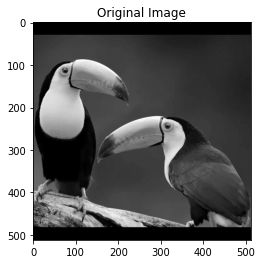

In [ ]:
clean_img = imageio.imread('pic1.png').astype('float32')
plt.imshow(clean_img, cmap='gray')
plt.title('Original Image');

# add white Gaussian noise with standard deviation of sigma

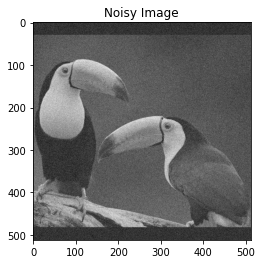

In [ ]:
sigma = 20
noisy_img = clean_img + np.random.normal(scale=sigma, size=clean_img.shape)
plt.figure()
plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy Image');

In [ ]:
p = 8    # patch size
N = noisy_img.shape[0]
Y = extract_patches(noisy_img, patch_size=p)
assert Y.shape == (p**2, (N-p+1)**2), 'Invlid patch extraction'

In [ ]:
def normilize(A:np.ndarray):

    column_num=A.shape[1]
    normilized_mat=np.copy(A)
    #-------------------------
    for c in range(column_num):
        normilized_mat[:,c]/=norm(A[:,c])
    #--------------------------    
    return normilized_mat  

## sparse vector learning 

In [ ]:
def MP(D: np.ndarray, Y: np.ndarray, tol:float) -> np.ndarray:
    
    threshold=D.shape[0] * tol ** 2
    num_sample=Y.shape[1]
    X=np.zeros([D.shape[1],num_sample])
    #--------------------------
    normilize_dic=normilize(D)  # it's good to normilize dictionary (helps us in time complexity)
    #--------------------------
    for i in range(num_sample):
        x_i=np.copy(X[:,i])
        residu=np.copy(Y[:,i]-np.dot(D,x_i))
        
        while(norm(residu)**2>threshold):
             #-------------------------
             error=norm(residu)**2-(np.dot(normilize_dic.T,residu))**2
             #---------------------------    
             indice=np.argmin(error)    
             #---------------------------
             z_star=np.dot(D[:,indice].T,residu)/(norm(D[:,indice])**2)
             x_i[indice]+=z_star
             residu=np.copy(Y[:,i]-np.dot(D,x_i))
        X[:,i]=x_i     
    
    return X


def OMP(D: np.ndarray, Y: np.ndarray, tol:float) -> np.ndarray:

    threshold=D.shape[0] * tol ** 2
    num_sample=Y.shape[1]
    X=np.zeros([D.shape[1],num_sample])
    #--------------------------
    normilize_dic=normilize(D) # it's good to normilize dictionary (helps us in time complexity)
    #--------------------------
    for i in range(num_sample):
        indice_list=[]
        x_i=np.copy(X[:,i])
        residu=np.copy(Y[:,i]-np.dot(D,x_i))

        while(norm(residu)**2>threshold):
             #-------------------------
             error=norm(residu)**2-(np.dot(normilize_dic.T,residu))**2
             #---------------------------    
             indice=np.argmin(error)    
             #---------------------------
             indice_list.append(indice)
             D_k=D[:,indice_list]
             x_i=dot(pinv(D_k),Y[:,i])
             residu=np.copy(Y[:,i]-np.dot(D_k,x_i))
        #------------------------------      
        if(len(indice_list)!=0):
            X[indice_list,i]=x_i   
        else :
            X[:,i]=x_i      
    
    return X

## dictionary learning

In [ ]:
def MOD(Y:np.ndarray, X:np.ndarray):
    D=dot(dot(Y,X.T),pinv(dot(X,X.T)))
    return D

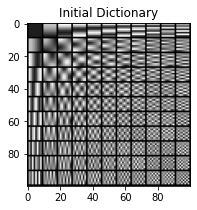

In [ ]:
C = 1.075    # noise gain
multiplier = 0.5    # fraction of the noisy image added to the final result

initial_dict = np.load('initial_dictionary.npy') # initialize dictionary to an overcomplete DCT dictionary
    
# visualize the initial dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(initial_dict), cmap='gray');
plt.title('Initial Dictionary');

### MOD + MP

In [ ]:
# training step
final_dict, X = train(Y, initial_dict, num_iter=10, C=1.075, sigma=sigma, sparse_code=MP, dict_update=MOD)

  0%|          | 0/10 [00:00<?, ?it/s]

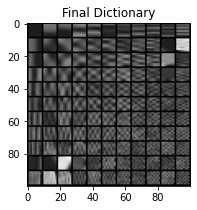

In [ ]:
# visualize the final dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(final_dict), cmap='gray');
plt.title('Final Dictionary');

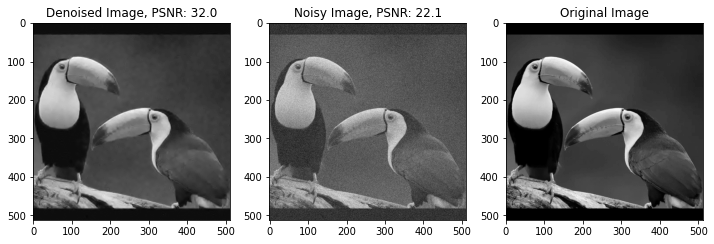

In [ ]:
# reconstruct the image and compare with the noisy and original one
denoised_img = reconstruct_image(initial_dict, X, noisy_img, p, m=0.1)
evaluate(clean_img, noisy_img, denoised_img)

### MOD + OMP

In [ ]:
# training step
final_dict, X = train(Y, initial_dict, num_iter=10, C=1.075, sigma=sigma, sparse_code=OMP, dict_update=MOD)

  0%|          | 0/10 [00:00<?, ?it/s]

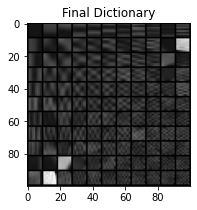

In [ ]:
# visualize the final dictionary
plt.figure(figsize=(3, 3))
plt.imshow(visualize_dict(final_dict), cmap='gray');
plt.title('Final Dictionary');

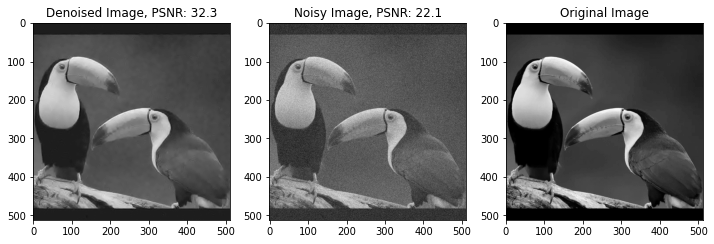

In [ ]:
# reconstruct the image and compare with the noisy and original one
denoised_img = reconstruct_image(initial_dict, X, noisy_img, p, m=0.1)
evaluate(clean_img, noisy_img, denoised_img)